# Plots and analysis
This notebook contains plots and other code to explore guesses of the players of the game.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


## Data

NB: Don't forget to run all the scripts prior to this step.

In [23]:
# Load all inputs
df_raw = pd.read_csv('../data/answers.csv',error_bad_lines=False)
df2_raw = pd.read_csv('../data/ground_truth.csv',error_bad_lines=False).apply(lambda s:s.str.replace('"', ""))

In [3]:
#check
#print(df_raw.shape, df2_raw.shape)
df_raw.head()


,Timestamp,Current URL,Player,Guess
0,2021/01/14 11:20:26 PM GMT+1,URL11,Player1,Player2
1,2021/01/14 11:21:25 PM GMT+1,URL11,Player2,Player10
2,2021/01/14 11:21:45 PM GMT+1,URL11,Player7,Player1
3,2021/01/14 11:22:01 PM GMT+1,URL11,Player8,Player11
4,2021/01/14 11:22:21 PM GMT+1,URL11,Player6,Player1


In [24]:
# change column titles
df2_raw.rename(columns = {df2_raw.columns[1]:'Player'},inplace=True)
df2_raw.rename(columns = {df2_raw.columns[2]:'URL'},inplace=True)
df2_raw.head()
#df_raw.shape

,Timestamp,Player,URL
0,2021/01/07 1:27:41 PM GMT+1,Player1,URL1
1,2021/01/08 3:42:51 PM GMT+1,Player2,URL2
2,2021/01/09 5:34:03 PM GMT+1,Player3,URL3
3,2021/01/10 7:34:16 PM GMT+1,Player6,URL6
4,2021/01/11 8:24:53 PM GMT+1,Player10,URL10


In [5]:
# which urls
urls = df_raw['Current URL'].unique()
print(urls.tolist())

# which players
players = df_raw['Player'].unique()

# which guesses
guess = df_raw['Guess'].unique()

['URL11', 'URL10', 'URL6']


In [6]:
df_player_guess=df_raw.loc[:,['Player','Guess']]
df_player_guess.head()

,Player,Guess
0,Player1,Player2
1,Player2,Player10
2,Player7,Player1
3,Player8,Player11
4,Player6,Player1


In [7]:
# looking at the guesses per URL slice
df_url_guess=df_raw.loc[:,['Current URL','Guess']] #only guesses per URL
df_url_guess.head()



,Current URL,Guess
0,URL11,Player2
1,URL11,Player10
2,URL11,Player1
3,URL11,Player11
4,URL11,Player1


# Statistics

## Guesses stats

### Most popular and least votes

In [8]:
# code from https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675
# function creating leaderboard

def create_leaderboard(df,col_name, tab_header):
    leaderboard = df[col_name].value_counts(ascending=True)
    s = pd.Series(leaderboard, name=tab_header)
    df2 = s.to_frame().sort_values(tab_header, ascending=False)
    return df2

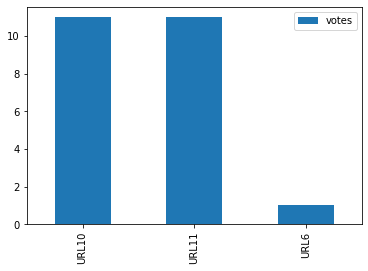

In [9]:
# total number of votes per link
votes_links = create_leaderboard(df_raw,'Current URL','votes')
votes_links.plot.bar(y='votes'); # plot histogram


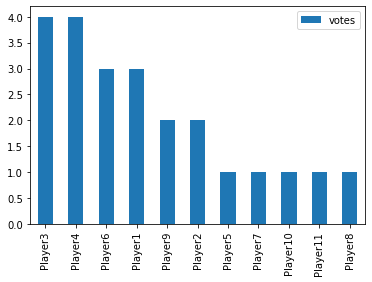

In [10]:
# total votes for each player

total_votes = create_leaderboard(df_raw,'Guess','votes')
total_votes.plot.bar(y='votes'); # plot histogram

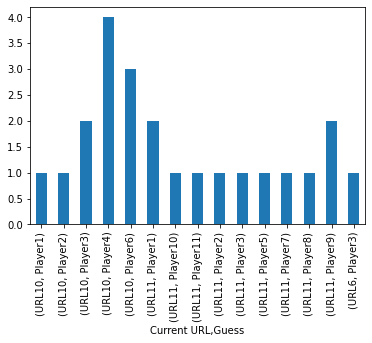

In [11]:
# stats of guesses per URL

guess_stats = df_raw.groupby(by=['Current URL', 'Guess'])['Guess'].count()
s = pd.Series(guess_stats, name="votes")
df_guess = s.to_frame().sort_values("votes", ascending=False).reset_index()
guess_stats.plot.bar(x='Current URL'); # plot histogram

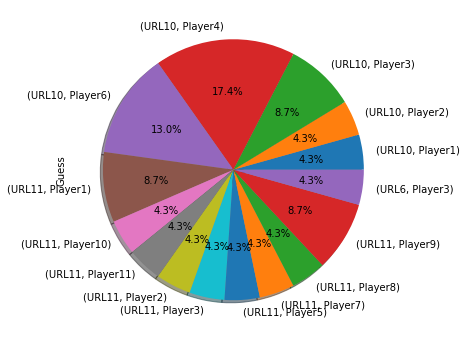

In [12]:
# combined pie chart
guess_stats.plot.pie(subplots=True,y='votes',figsize=(6, 6),autopct='%1.1f%%',shadow = True);

In [13]:
print(df_guess.columns)

Index(['Current URL', 'Guess', 'votes'], dtype='object')


In [14]:
df = df_guess.loc[df_guess['Current URL'] == 'URL6']
df.loc[:,['Guess','votes']]

,Guess,votes
14,Player3,1


In [15]:
url='URL10'
df2_raw.loc[df2_raw['URL'] == url]

,Timestamp,Player,URL


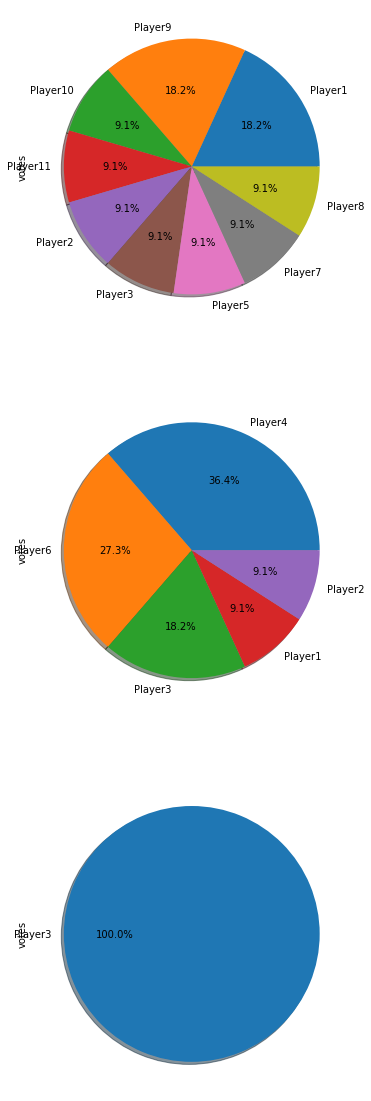

In [16]:
#pie chart per URL

fig, axes = plt.subplots(len(urls),1,figsize=(30, 20)) #ncols=len(urls)#,)
#for i,ax in enumerate(axes):
for i,ax in enumerate(axes):
    url = urls[i]
    temp_df = df_guess.loc[df_guess['Current URL'] == url]
    #explode = [0] * len(players)
    explode = [0] * len(temp_df.index)
    temp_df.loc[:,['Guess','votes']].plot.pie(ax=ax,subplots=True,labels = temp_df['Guess'], y='votes', autopct='%1.1f%%',shadow = True,explode=explode);
    ax.get_legend().remove()
plt.show()


## Ground truth related stats

### TBD

In [17]:
#TODO

# Appendix: Graphs

In [18]:
# first dumb graph, ignores weights
G = nx.from_pandas_edgelist(df_raw, 'Player', 'Guess',)

# and now we try multigraph
M = nx.from_pandas_edgelist(df_raw, 'Player', 'Guess', create_using=nx.MultiDiGraph())


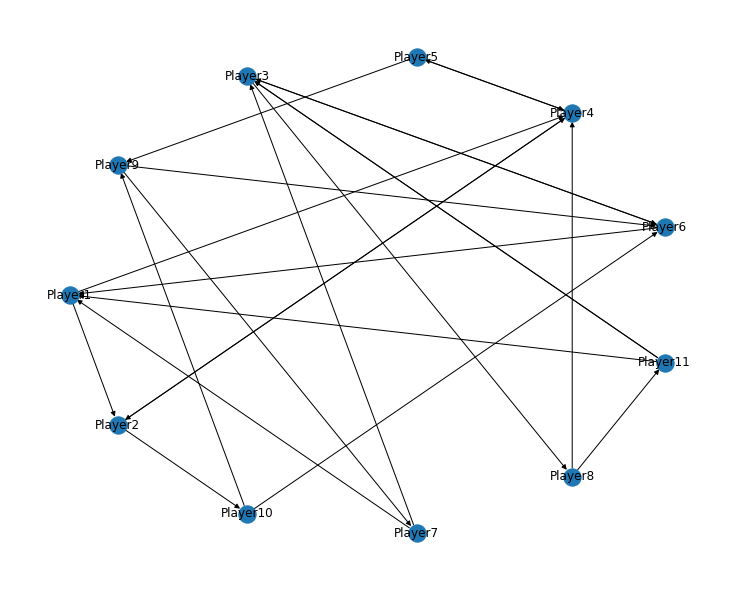

In [19]:
# plot spacy multigraph of who voted for whom
plt.figure(figsize=(10, 8))
nx.draw_shell(M, with_labels=True)

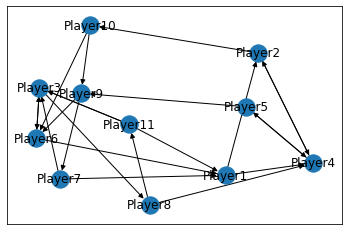

In [20]:
# a bit more dense
nx.draw_networkx(M)

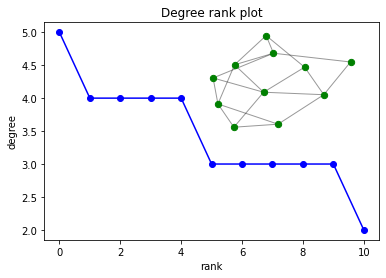

In [21]:
# another look via degree sequences
# source: from networkx gallery

degree_dist = sorted([vote for player, vote in G.degree()], reverse=True)
dmax = max(degree_dist)

plt.plot(degree_dist, "b-", marker="o")
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
# not implemented for directed graph?
plt.axes([0.5, 0.5, 0.35, 0.35])
g_cc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=False)[0])
pos = nx.spring_layout(g_cc)
plt.axis("off")
nx.draw_networkx_nodes(g_cc, pos, node_size=40, node_color="green")
nx.draw_networkx_edges(g_cc, pos, arrowstyle="->", arrowsize=10, alpha=0.4)